In [1]:
from scipy.io import wavfile
import torch
import sounddevice as sd
import collections
import random
import matplotlib.pyplot as plt
import os, glob
import torch
from torch import nn
import torch.nn.functional as F
import tensorboardX
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

C:\Users\alsa0217\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
def show_loudness(data):
    c = collections.Counter(data)
    m = dict(sorted(dict(c).items()))
    
    plt.figure(figsize=(16, 5))
    plt.semilogy(list(m.keys()), list(m.values()))
    plt.show()
    
    lowest_count = (data < -10000).sum()
    highest_count = (data > 10000).sum()
    print('lowest_count:', lowest_count, lowest_count * 100 / len(data), '%' )
    print('highest_count:', highest_count, lowest_count * 100 / len(data), '%')

In [3]:
device = torch.device("cuda")

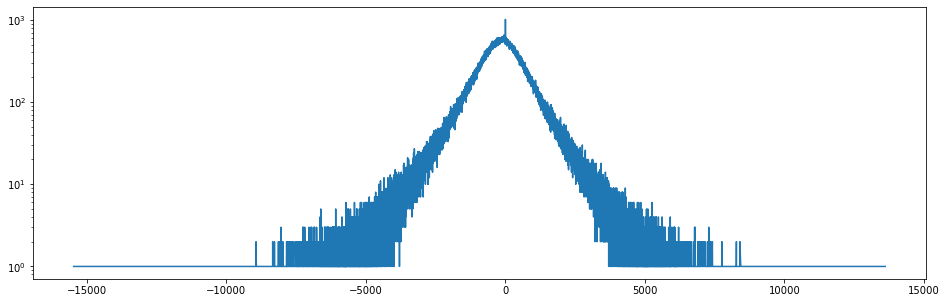

lowest_count: 27 0.00247950277704311 %
highest_count: 3 0.00247950277704311 %
11025
(4796640,)


In [4]:
samplerate, data = wavfile.read('./data/voice/0015.wav')
_, noise = wavfile.read('./data/noise/00713.wav')
#sd.play(data[:50000], samplerate)
show_loudness(noise)
print(samplerate)
print(data.shape)

In [5]:
class PixelShuffle1D(torch.nn.Module):
    """
    1D pixel shuffler. https://arxiv.org/pdf/1609.05158.pdf
    Upscales sample length, downscales channel length
    "short" is input, "long" is output
    """
    def __init__(self, upscale_factor):
        super(PixelShuffle1D, self).__init__()
        self.upscale_factor = upscale_factor

    def forward(self, x):
        batch_size = x.shape[0]
        short_channel_len = x.shape[1]
        short_width = x.shape[2]

        long_channel_len = short_channel_len // self.upscale_factor
        long_width = self.upscale_factor * short_width

        x = x.contiguous().view([batch_size, self.upscale_factor, long_channel_len, short_width])
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, long_channel_len, long_width)

        return x

In [16]:
class ImineggNet1(nn.Module):
    def __init__(self, upscale_factor):
        super().__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(1, 128, 15, 5, 0)
        self.conv2 = nn.Conv1d(128, 256, 15, 10, 10)
        self.conv3 = nn.Conv1d(256, 512, 15, 10, 5)
        #self.conv4 = nn.Conv1d(512, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        
        self.pixel_shuffle = PixelShuffle1D(512)

       
    def downsampling(self, x):
        #print('INPUT', x.shape)
        x = self.relu(self.conv1(x))
        #print(x.shape)
        x = self.relu(self.conv2(x))
        print(x.shape)
        x = self.relu(self.conv3(x))
        print(x.shape)
        
        x = self.relu(nn.Conv1d(512, 1024, 15, 10, 5)(x))
        print(x.shape)
        x = self.relu(nn.Conv1d(1024, 2048, 15, 10, 5)(x))
        print(x.shape)
        
        return x
        
    def upsampling(self, x):
        #print(x.shape)
        x = PixelShuffle1D(64)(x) # 32 left
        
        x = self.relu(nn.Conv1d(32, 32, 15, 1, 7)(x))
        
        print(x.shape)
        
        x = PixelShuffle1D(32)(x) # 1 left
        
        print(x.shape)
        return x

    def calc(self, x):
        z = x
        x = self.downsampling(x)
        x = self.upsampling(x)
        return x[:,:,:22050] + z

iminegg_net = ImineggNet1(2)


In [17]:
iminegg_net.downsampling(torch.zeros(1, 1, train_sample_length).float())

torch.Size([1, 256, 442])
torch.Size([1, 512, 44])
torch.Size([1, 1024, 4])


RuntimeError: Calculated padded input size per channel: (14). Kernel size: (15). Kernel size can't be greater than actual input size

In [7]:
#sd.play(data[:samplerate*2] + noise[samplerate:samplerate*3] // 10 , samplerate)

In [7]:
voices = []
for file in glob.glob("./data/voice/*.wav"):
    samplerate, data = wavfile.read(file)
    voices.append(torch.from_numpy(data).to(device).float() / 32768)
noises = []
for file in glob.glob("./data/noise/*.wav"):
    _, data = wavfile.read(file)
    noises.append(torch.from_numpy(data).to(device).float() / 32768)
    
train_sample_length = int(samplerate * 2)
silence = torch.zeros(train_sample_length).to(device)


<ipython-input-7-0f1e9bbd93c2>:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  voices.append(torch.from_numpy(data).to(device).float() / 32768)


In [8]:
#sd.play(voices[5][:train_sample_length*3].cpu(), samplerate)

In [9]:

class Iminegg(pl.LightningModule):

    def __init__(self, net):
        super().__init__()
        self.net = net

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x = torch.unsqueeze(batch['input'], 1)
        y = torch.unsqueeze(batch['target'], 1)
        
        x_hat = self.net.calc(x)
        
        #loss = F.mse_loss(x_hat, y) * 100
        loss = torch.norm(x_hat - y, p=1) / 22050
        #print((x_hat-y).abs().max(), loss.item())
        
        logs={"train_loss": loss}
        batch_dictionary={
            #REQUIRED: It ie required for us to return "loss"
            "loss": loss,
            
            #optional for batch logging purposes
            "log": logs,
        }
        return batch_dictionary

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_epoch_end(self,outputs):
        #  the function is called after every epoch is completed

        # calculating average loss  
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        # calculating correect and total predictions
        correct=1
        total=2

        # creating log dictionary
        tensorboard_logs = {'loss': avg_loss,"Accuracy": correct/total}

        epoch_dictionary={
            # required
            'loss': avg_loss,
            
            # for logging purposes
            'log': tensorboard_logs}

        return epoch_dictionary
    
iminegg = Iminegg(iminegg_net)

In [13]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, data_len):
        super().__init__()
        self.data_len = data_len

    def _voice_sample(self):
        s = voices[random.randint(0, len(voices) - 1)]
        offset = random.randint(0, len(s) - train_sample_length - 1)
        return s[offset:offset + train_sample_length]
    
    def _noise_sample(self):
        s = noises[random.randint(0, len(noises) - 1)]
        offset = random.randint(0, len(s) - train_sample_length - 1)
        return s[offset:offset + train_sample_length]
        
    def generate_with_noise(self):
        voice = self._voice_sample()
        noise = self._noise_sample()
        return {'input': voice + noise / 10, 'target': voice}
    
    def generate_voice(self):
        voice = self._voice_sample()
        return {'input': voice, 'target': voice}
    
    def generate_noise(self):
        noise = self._noise_sample()
        return {'input': noise / 10, 'target': silence}
    
    def generate(self):
        r = random.uniform(0, 1)
        if r < 1.0:
            return self.generate_with_noise()
        if r < 1.0:
            return self.generate_voice()
        return self.generate_noise()
        
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.data_len
    
    def __next__(self):
        return self.generate()

In [14]:
ds_train = MyIterableDataset(100000)
ds_validate = MyIterableDataset(5000)

In [15]:
tb_logger = pl_loggers.TensorBoardLogger('logs/')

trainer = pl.Trainer(max_epochs=4, gpus=1, logger=tb_logger)
train_set = DataLoader(ds_train, batch_size=300)
validate_set = DataLoader(ds_validate, batch_size=100)
trainer.fit(iminegg, train_set, validate_set)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type        | Params
-------------------------------------
0 | net  | ImineggNet1 | 2 M   


Saving latest checkpoint..


1

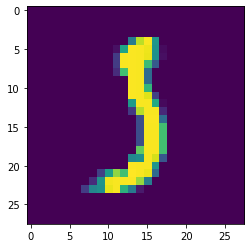

In [94]:
#dataset[101][0].shape
plt.imshow(dataset[132][0].reshape(-1, 28))

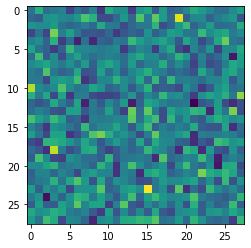

In [217]:
plt.imshow(
autoencoder.decoder(
    autoencoder.forward(dataset[115][0].reshape(-1))
).reshape(28, -1).detach().numpy() )


<ipython-input-8-56907183a47b>:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  voices.append(torch.from_numpy(data).to(device).float())


In [254]:
dl = DataLoader(ds, batch_size=4)
next(iter(dl))

{'input': tensor([[-1703, -1614, -1330,  ...,   312,   633,   757],
         [ -254,  -104,   170,  ..., 10608, 11919, 12667],
         [-3496, -5741, -5815,  ..., -7884, -3682,  -280],
         [ 6611,  -565,   246,  ..., -1606, -1655, -1527]], device='cuda:0',
        dtype=torch.int16),
 'target': tensor([[    0.,     0.,     0.,  ...,     0.,     0.,     0.],
         [ -254.,  -104.,   170.,  ..., 10608., 11919., 12667.],
         [    0.,     0.,     0.,  ...,     0.,     0.,     0.],
         [ 6475.,  -632.,   296.,  ..., -1625., -1664., -1521.]],
        device='cuda:0')}

In [68]:
inp = ds_train.generate_with_noise()['input'].cpu()
sd.play(inp, samplerate)

In [71]:
outp = iminegg_net.calc(torch.unsqueeze(torch.unsqueeze(inp, 0), 0)).reshape(-1)
outp.shape
sd.play(outp.detach().numpy(), samplerate)

In [42]:
sd.play(ds_train.generate_with_noise()['input'].cpu(), samplerate)